# About Dataset
This dataset is originally from the National Institute of Diabetes and Digestive and Kidney
Diseases. The objective of the dataset is to diagnostically predict whether a patient has diabetes,
based on certain diagnostic measurements included in the dataset. Several constraints were placed
on the selection of these instances from a larger database. In particular, all patients here are females
at least 21 years old of Pima Indian heritage.2
From the data set in the (.csv) File We can find several variables, some of them are independent
(several medical predictor variables) and only one target dependent variable (Outcome).


In [ ]:
import random

# Set a seed for the random number generator
random.seed(42)  # You can choose any integer as the seed

In [ ]:
!pip install shap

In [ ]:
# Libraries
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
from sklearn.preprocessing import scale
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import roc_auc_score,roc_curve
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error
from warnings import filterwarnings
import random
filterwarnings('ignore')


# DATASET

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 500)

diabetes = pd.read_csv("/content/heart_failure_clinical_records_dataset.csv")
df = diabetes.copy()
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.000,0,582,0,20,1,265000.000,1.900,130,1,0,4,1
1,55.000,0,7861,0,38,0,263358.030,1.100,136,1,0,6,1
2,65.000,0,146,0,20,0,162000.000,1.300,129,1,1,7,1
3,50.000,1,111,0,20,0,210000.000,1.900,137,1,0,7,1
4,65.000,1,160,1,20,0,327000.000,2.700,116,0,0,8,1


In [ ]:
df.columns

Index(['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes', 'ejection_fraction', 'high_blood_pressure', 'platelets', 'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'time', 'DEATH_EVENT'], dtype='object')

## Removing Outliers

In [ ]:
df.DEATH_EVENT.value_counts()

0    203
1     96
Name: DEATH_EVENT, dtype: int64

In [ ]:
controllable_feature = ['diabetes','anaemia','creatinine_phosphokinase', 'serum_sodium','smoking',\
                        'high_blood_pressure','platelets','serum_creatinine','ejection_fraction']
#features which a user can potentially alter by altering their lifestyles apparently

In [ ]:
X = df[controllable_feature]
y = df['DEATH_EVENT']

## Splitting Data and Training

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test,y_train,y_test= train_test_split(X,y,random_state=42,test_size=0.20)
X_train.shape, X_test.shape, y_test.shape,y_train.shape

((239, 9), (60, 9), (60,), (239,))

In [ ]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test= sc.transform(X_test)
X_test_df = pd.DataFrame(X_test, columns=['diabetes', 'anaemia', 'creatinine_phosphokinase', 'serum_sodium', 'smoking', 'high_blood_pressure',\
                                                          'platelets', 'serum_creatinine', 'ejection_fraction'])


In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state = 42)
rf_model = rf.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.72      0.83      0.77        35
           1       0.70      0.56      0.62        25

    accuracy                           0.72        60
   macro avg       0.71      0.69      0.70        60
weighted avg       0.71      0.72      0.71        60



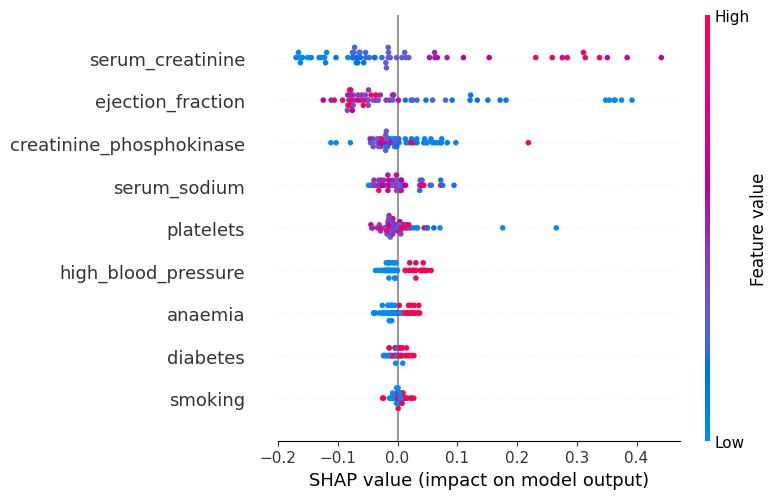

In [ ]:
import shap
explainer = shap.TreeExplainer(rf, X_train)

# Calculate SHAP values for the test data
shap_values = explainer.shap_values(X_test, check_additivity=False)

# Create a summary plot for feature importance across all predictions
shap.summary_plot(shap_values[1], X_test, feature_names=X.columns)

In [ ]:
X_test_ID = X_test_df.copy()
X_test_ID['ID'] = [i for i in range(1, len(X_test)+1)]

In [ ]:
shap_df = pd.DataFrame(shap_values[1], columns=X_test_df.columns)
shap_df['ID'] = list(X_test_ID['ID'])
class_probabilities = rf.predict_proba(X_test)[:, 1]
predicted_labels = rf.predict(X_test)
shap_df['prediction'] = predicted_labels
shap_df['class_prob'] = class_probabilities

In [ ]:
shap_df.head()

,diabetes,anaemia,creatinine_phosphokinase,serum_sodium,smoking,high_blood_pressure,platelets,serum_creatinine,ejection_fraction,ID,prediction,class_prob
0,-0.004,-0.011,-0.002,-0.002,-0.025,-0.014,0.176,0.311,-0.008,1,1,0.720
1,0.001,0.037,-0.015,-0.002,0.012,-0.037,-0.018,-0.075,-0.072,2,0,0.130
2,-0.013,-0.030,0.028,-0.026,0.003,-0.004,-0.008,-0.012,0.023,3,0,0.260
3,-0.003,0.016,0.059,0.041,-0.008,0.043,0.022,0.284,-0.032,4,1,0.720
4,0.002,-0.014,0.050,-0.016,-0.008,-0.019,-0.013,-0.020,-0.111,5,0,0.150


In [ ]:
X_test_df.head()

,diabetes,anaemia,creatinine_phosphokinase,serum_sodium,smoking,high_blood_pressure,platelets,serum_creatinine,ejection_fraction
0,-0.826,-0.878,0.005,-0.094,1.479,-0.736,-2.247,1.322,0.149
1,-0.826,1.139,-0.295,0.808,1.479,-0.736,1.058,-0.491,-0.281
2,1.210,-0.878,1.974,0.583,-0.676,-0.736,0.761,-0.289,-0.711
3,-0.826,1.139,-0.481,-0.772,1.479,1.358,1.335,8.070,-0.281
4,1.210,-0.878,-0.503,0.808,-0.676,-0.736,-0.270,-0.189,0.149


In [ ]:
X_test_n = X_test_df.copy()
X_test_n[controllable_feature] = sc.inverse_transform(X_test_df[controllable_feature])

In [ ]:
X_test_n['ID'] = [i for i in range(1, len(X_test)+1)]
X_test_n['label'] = list(y_test)

In [ ]:
random_state = 42

class_0_examples = X_test_n[X_test_n['label'] == 0]
class_1_examples = X_test_n[X_test_n['label'] == 1]

X_test_llm = pd.concat([class_0_examples.sample(12, random_state=random_state),
                        class_1_examples.sample(13, random_state=random_state)])

In [ ]:
X_test_llm

,diabetes,anaemia,creatinine_phosphokinase,serum_sodium,smoking,high_blood_pressure,platelets,serum_creatinine,ejection_fraction,ID,label
46,1.000,0.000,212.000,136.000,1.000,1.000,389000.000,1.000,17.000,47,0
22,0.000,0.000,143.000,135.000,0.000,0.000,246000.000,2.400,25.000,23,0
44,1.000,1.000,270.000,145.000,0.000,0.000,227000.000,3.400,35.000,45,0
39,0.000,0.000,582.000,137.000,0.000,0.000,263358.030,1.180,60.000,40,0
26,1.000,0.000,2695.000,137.000,0.000,0.000,241000.000,1.000,40.000,27,0
49,1.000,1.000,122.000,145.000,0.000,0.000,267000.000,1.200,60.000,50,0
32,1.000,1.000,159.000,138.000,0.000,0.000,302000.000,1.200,30.000,33,0
21,0.000,0.000,53.000,143.000,0.000,1.000,286000.000,2.300,50.000,22,0
14,0.000,1.000,607.000,138.000,1.000,0.000,216000.000,0.600,40.000,15,0
27,1.000,1.000,96.000,136.000,0.000,1.000,271000.000,0.700,60.000,28,0


In [ ]:
shap_df_llm = shap_df[shap_df['ID'].isin(X_test_llm['ID'])]

In [ ]:
def getPrompts():
  """
  Returns prompts for natural language interaction with a machine learning model.

  Returns:
    A tuple of five strings:
      prompt1: Introduction and model description.
      prompt2: Patient's feature values prompt.
      prompt3: SHAP values prompt.
      prompt4: Patient's question prompt.
      prompt5: Answer prompt.
      prompt6: Explanation context prompt.
  """
  prompt1 = """Hello! We are using natural language to interface with a machine-learning medical model, aiming to make complex algorithmic predictions accessible and understandable to patients. We trained a Random Forest Classifier model to predict the likelihood of heart failure based on vital signs patient data.
Using the patient's data and SHAP values, explain how the model works in simple terms. Keep in mind to Explain this to a patient unfamiliar with machine learning and SHAP values. If the patient asks for lifestyle suggestions, recommend changes to two key features that can improve survival chances.
Features: ['diabetes', 'anaemia','creatinine_phosphokinase','serum_sodium','smoking','high_blood_pressure', 'platelets','serum_creatinine','ejection_fraction'].Units of features are described as :Creatinine (Level of the CPK enzyme in the blood (mcg/L)),Aneamia (Decrease of red blood cells or hemoglobin),Diabetes (If the patient has diabetes),Ejection Fraction (Percentage of blood leaving the heart at each contraction (percentage)),high_blood_pressure (If the patient has high_blood_pressure),Platelets (Platelets in the blood (kiloplatelets/mL)),Serum Creatinine (Level of serum creatinine in the blood (mg/dL)),Serum Sodium (Level of serum sodium in the blood (mEq/L)),Smoking (If the patient smokes or not (boolean)).
Model prediction probability( ranges from  [(0: No Heart Failure),( 1: Heart Failure)]):"""

  prompt2 = """\nHere are the patient's feature values:"""

  prompt3 = """\nAnd here are the corresponding SHAP values for this patient:"""

  prompt4 = """\nThe patient asks:"""

  return prompt1, prompt2, prompt3, prompt4


In [ ]:
def generate_final_prompt(prob, feature_values, shap_values, ques):
    prompt1, prompt2, prompt3, prompt4 = getPrompts()
    prompt = (
        prompt1 + str(prob) +
        prompt2 + str(feature_values) +
        prompt3 + str(shap_values) +
        prompt4 +
        ques[0] +
        ques[1]
    )
    return prompt

In [ ]:
question_list_high_risk = [
                           ["""What could be done to lower the risk score?""",""" Based on the model's predictions and the SHAP values, please suggest specific numerical changes to the two most impactful features. Format your suggestions as follows: 'Feature: [Feature Name], Suggested Change: [Exact Numerical Value]' Your Answer: """],
                           ["""How would a change in high_blood_pressure (or/and, 'diabetes', 'anaemia', 'creatinine_phosphokinase', 'serum_sodium', 'smoking', 'platelets', 'serum_creatinine', 'ejection_fraction') affect this risk score?""",""" Based on the model's predictions and the SHAP values, please suggest specific numerical changes to the two most impactful features. Format your suggestions as follows: 'Feature: [Feature Name], Suggested Change: [Exact Numerical Value]' Your Answer: """],
                           ["""Why is the risk score so high?""",""" Your Answer:"""]
                           ]

In [ ]:
question_list_low_risk = [
                          ["""Are there specific lifestyle changes I can make to maintain this low risk?""",""" Based on the model's predictions and the SHAP values, please suggest specific numerical changes to the two most impactful features. Format your suggestions as follows: 'Feature: [Feature Name], Suggested Change: [Exact Numerical Value]' Your Answer: """],
                          ["""How would a change in high_blood_pressure (or/and, 'diabetes', 'anaemia', 'creatinine_phosphokinase', 'serum_sodium', 'smoking', 'platelets', 'serum_creatinine', 'ejection_fraction') affect this risk score?""",""" Based on the model's predictions and the SHAP values, please suggest specific numerical changes to the two most impactful features. Format your suggestions as follows: 'Feature: [Feature Name], Suggested Change: [Exact Numerical Value]' Your Answer: """],
                          ["""What factors contributed to my low risk of heart disease?""",""" Your Answer:"""]
                          ]

In [ ]:
prompt_entries = []
for index, row in shap_df_llm.iterrows():
  shap_values = list(row[['diabetes', 'anaemia','creatinine_phosphokinase','serum_sodium','smoking','high_blood_pressure', 'platelets','serum_creatinine','ejection_fraction']])
  features= X_test_llm[X_test_llm['ID'] == row['ID']].iloc[0]
  features_values = list(features[['diabetes', 'anaemia','creatinine_phosphokinase','serum_sodium','smoking','high_blood_pressure', 'platelets','serum_creatinine','ejection_fraction']])
  pred = row['class_prob']
  if pred>=0.5:
    question_list = question_list_high_risk
  else:
    question_list = question_list_low_risk
  for ques in question_list:
    prompt = generate_final_prompt(pred,features_values,shap_values,ques)
    prompt_entries.append([row['ID'], prompt])

In [ ]:
df_prompts = pd.DataFrame(prompt_entries, columns=['ID', 'Prompt'])

In [ ]:
df_prompts

,ID,Prompt
0,3.000,Hello! We are using natural language to interf...
1,3.000,Hello! We are using natural language to interf...
2,3.000,Hello! We are using natural language to interf...
3,4.000,Hello! We are using natural language to interf...
4,4.000,Hello! We are using natural language to interf...
5,4.000,Hello! We are using natural language to interf...
6,7.000,Hello! We are using natural language to interf...
7,7.000,Hello! We are using natural language to interf...
8,7.000,Hello! We are using natural language to interf...
9,13.000,Hello! We are using natural language to interf...


# Reshaping


In [ ]:
df_prompts['sort_index'] = df_prompts.index % 3
df_sorted = df_prompts.sort_values(by=['sort_index']).reset_index(drop=True)

In [ ]:
df_sorted.to_csv('PromptsOutput.csv', index=False)

# LLM Inferences

Given prompt, This block infers from Llama2

In [ ]:
!pip install -qU \
  transformers==4.31.0 \
  sentence-transformers==2.2.2 \
  pinecone-client==2.2.2 \
  datasets==2.14.0 \
  accelerate==0.21.0 \
  einops==0.6.1 \
  langchain==0.0.240 \
  xformers==0.0.20 \
  bitsandbytes==0.41.0

In [ ]:
from torch import cuda, bfloat16
import transformers

model_id = 'NousResearch/Llama-2-7b-chat-hf'

device = f'cuda:{cuda.current_device()}' if cuda.is_available() else 'cpu'
bnb_config = transformers.BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type='nf4',
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=bfloat16
)

hf_auth = 'HF_AUTH_TOKEN'
model_config = transformers.AutoConfig.from_pretrained(
    model_id,
    use_auth_token=hf_auth
)

model = transformers.AutoModelForCausalLM.from_pretrained(
    model_id,
    trust_remote_code=True,
    config=model_config,
    quantization_config=bnb_config,
    device_map='auto',
    use_auth_token=hf_auth
)
model.eval()
print(f"Model loaded on {device}")
tokenizer = transformers.AutoTokenizer.from_pretrained(
    model_id,
    use_auth_token=hf_auth
)
generate_text = transformers.pipeline(
    model=model, tokenizer=tokenizer,
    return_full_text=True,
    task='text-generation',
    temperature=0.0,  # 'randomness' of outputs, 0.0 is the min and 1.0 the max
    max_new_tokens=1024,  # mex number of tokens to generate in the output
    repetition_penalty=1.1  # without this output begins repeating
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Model loaded on cuda:0


In [ ]:
res=generate_text("""Hello! We are using natural language to interface with a machine-learning medical model, aiming to make complex algorithmic predictions accessible and understandable to patients. We trained a Random Forest Classifier model to predict the likelihood of heart failure based on vital signs patient data. Using the patient's data and SHAP values, explain how the model works in simple terms. Keep in mind to Explain this to a patient unfamiliar with machine learning and SHAP values. If the patient asks for lifestyle suggestions, recommend changes to two key features that can improve survival chances. Features: ['diabetes', 'anaemia','creatinine_phosphokinase','serum_sodium','smoking','high_blood_pressure', 'platelets','serum_creatinine','ejection_fraction'].Units of features are described as :Creatinine (Level of the CPK enzyme in the blood (mcg/L)),Aneamia (Decrease of red blood cells or hemoglobin),Diabetes (If the patient has diabetes),Ejection Fraction (Percentage of blood leaving the heart at each contraction (percentage)),high_blood_pressure (If the patient has high_blood_pressure),Platelets (Platelets in the blood (kiloplatelets/mL)),Serum Creatinine (Level of serum creatinine in the blood (mg/dL)),Serum Sodium (Level of serum sodium in the blood (mEq/L)),Smoking (If the patient smokes or not (boolean)). Model prediction probability( ranges from [(0: No Heart Failure),( 1: Heart Failure)]):0.56 Here are the patient's feature values:[0.0, 1.0, 145.0, 137.0, 1.0, 0.0, 219000.0, 1.2, 25.0] And here are the corresponding SHAP values for this patient:[0.00450404761970276, 0.02866333314072108, 0.06309904721158091, -0.008537618569971529, 0.0010483331565046682, -0.002494285780703649, -0.00889333304570755, 0.01197785794531228, 0.18163261675392278] The patient asks:What could be done to lower the risk score? Based on the model's predictions and the SHAP values, please suggest specific numerical changes to the two most impactful features. Format your suggestions as follows: 'Feature: [Feature Name], Suggested Change: [Exact Numerical Value]' Your Answer:\n""")
res[0]['generated_text']

'Hello! We are using natural language to interface with a machine-learning medical model, aiming to make complex algorithmic predictions accessible and understandable to patients. We trained a Random Forest Classifier model to predict the likelihood of heart failure based on vital signs patient data. Using the patient\'s data and SHAP values, explain how the model works in simple terms. Keep in mind to Explain this to a patient unfamiliar with machine learning and SHAP values. If the patient asks for lifestyle suggestions, recommend changes to two key features that can improve survival chances. Features: [\'diabetes\', \'anaemia\',\'creatinine_phosphokinase\',\'serum_sodium\',\'smoking\',\'high_blood_pressure\', \'platelets\',\'serum_creatinine\',\'ejection_fraction\'].Units of features are described as :Creatinine (Level of the CPK enzyme in the blood (mcg/L)),Aneamia (Decrease of red blood cells or hemoglobin),Diabetes (If the patient has diabetes),Ejection Fraction (Percentage of bl

In [ ]:
from tqdm import tqdm  # Import tqdm for progress tracking

def execute_llm_query(text):
    res = generate_text(text+"\n")
    return f"{res[0]['generated_text']}"  # Use double curly braces inside the f-string

new_df = pd.DataFrame(columns=['ID', 'Prompt', 'sort_index', 'Generated_Text_llama7b'])

# Create a tqdm object for a progress bar
tqdm_pandas = tqdm(total=len(df_sorted), position=0, leave=True)

for index, row in df_sorted.iterrows():

    generated_text = execute_llm_query(row['Prompt'])
    print(generated_text)
    # Add the original data and the generated text to the new DataFrame
    new_df = new_df.append({
        'ID': row['ID'],
        'Prompt': row['Prompt'],
        'sort_index': row['sort_index'],
        'Generated_Text_llama7b': generated_text
    }, ignore_index=True)

    # Save the new DataFrame to a CSV file after processing each row
    new_df.to_csv("/content/drive/MyDrive/Med277/Llama inference/Heart failure dataset/progress_datagenerated_text_llama7b.csv", index=False)
    tqdm_pandas.update(1)

# Close the progress bar
tqdm_pandas.close()


# Applying LLM suggestions


This block checks suggestions provide by Llama 2 and applies it to input feaatures

In [ ]:
!pip install openai

In [ ]:
import pandas as pd
results_ = pd.read_csv('/content/drive/MyDrive/Med277/Llama inference/Heart failure dataset/progress_datagenerated_text_llama7b.csv')

In [ ]:
import os
os.environ["OPENAI_API_KEY"] = "<Your OPEN AI API KEY?"

In [ ]:
import asyncio
from openai import AsyncOpenAI
def generate_extraction_prompt(model_output):
    suggestion_marker = "Suggested Change: [Exact Numerical Value]' Your Answer: "
    suggestion_start = model_output.find(suggestion_marker)

    if suggestion_start != -1:
        suggestion_start += len(suggestion_marker)
        suggestion_text = model_output[suggestion_start:]
    else:
        suggestion_text = "No specific suggestions found."
    feature_values_start = model_output.find("Here are the patient's feature values:")
    feature_values_end = model_output.find("\nAnd here are the corresponding SHAP values")

    feature_values_text = model_output[feature_values_start:feature_values_end] if feature_values_start != -1 else "Original feature values not found."

    prompt = f"""I have received advice from a machine learning model about changes that should be made to a patient's lifestyle to reduce their risk of  heart disease. The advice includes the patient's original feature values and the suggested changes. Here are the details:


Model's Suggestions is\"\"\"
{suggestion_text}
\"\"\"

Original {feature_values_text}

Note: The features used in the model are ['diabetes', 'anaemia','creatinine_phosphokinase','serum_sodium','smoking','high_blood_pressure', 'platelets','serum_creatinine','ejection_fraction']. Units of features are described as :Creatinine (Level of the CPK enzyme in the blood (mcg/L)),Aneamia (Decrease of red blood cells or hemoglobin),Diabetes (If the patient has diabetes),Ejection Fraction (Percentage of blood leaving the heart at each contraction (percentage)),high_blood_pressure (If the patient has high_blood_pressure),Platelets (Platelets in the blood (kiloplatelets/mL)),Serum Creatinine (Level of serum creatinine in the blood (mg/dL)),Serum Sodium (Level of serum sodium in the blood (mEq/L)),Smoking (If the patient smokes or not (boolean)). Ensure that the final feature list reflects the changes as suggested by the model and maintains the same order as the original features.

Based on this information, please extract the specific changes recommended for each feature and update the original feature values accordingly. Create a final, adjusted feature list that incorporates these changes. Format your response as follows:
'Final_Feature_List:  ['adjusted diabetes', 'adjusted anaemia','adjusted creatinine_phosphokinase','adjusted serum_sodium','adjusted smoking','adjusted high_blood_pressure', 'adjusted platelets','adjusted serum_creatinine','adjusted ejection_fraction']'
What is Final_Feature_List containing only numerical values?
"""

    return prompt
response =[]
async def apply_model_suggestions(model_output,client):
  prompt = generate_extraction_prompt(model_output)
  print(prompt)
  completion = await client.chat.completions.create(model="gpt-3.5-turbo",messages=[{"role": "user","content":prompt}], temperature=0.0)
  response = completion.choices[0].message.content

  return response


client = AsyncOpenAI()


In [ ]:
suggested_df = pd.DataFrame(columns=['ID', 'Prompt', 'sort_index', 'Generated_Text_llama7b',"suggestion_vals"])
for index, row in results_.iterrows():
  generated_text = row['Generated_Text_llama7b']

  suggestion_vals = await apply_model_suggestions(generated_text,client)  # Replace with your actual function

  new_row = {
      'ID': row['ID'],
      'Prompt': row['Prompt'],
      'sort_index': row['sort_index'],
      'Generated_Text_llama7b': generated_text,
      'suggestion_vals': suggestion_vals
  }

  suggested_df = suggested_df.append(new_row, ignore_index=True)

In [ ]:
suggested_df.to_csv('/content/drive/MyDrive/Med277/Llama inference/Heart failure dataset/suggestions_by_llama7b_3.csv', index=False)

In [ ]:
import pandas as pd
import re

df = pd.read_csv('/content/drive/MyDrive/Med277/Llama inference/Heart failure dataset/suggestions_by_llama7b_3.csv')

def extract_numerical_list(input_string):
    match = re.search(r'\[([\d\s.,]+)\]', input_string)
    print(match)
    if match:
        return [float(val) for val in match.group(1).split(',')]
    else:
        return []

df['Numerical_List'] = df['suggestion_vals'].apply(extract_numerical_list)

df.to_csv('/content/drive/MyDrive/Med277/Llama inference/Heart failure dataset/suggestions_by_llama7b_4.csv', index=False)


# Compute final probability

This block computes probability after applying suggestions from llama2 in Numerical_List column

In [ ]:
import pandas as pd
suggest_ = pd.read_csv('/content/drive/MyDrive/Med277/Llama inference/Heart failure dataset/suggestions_by_llama7b_4.csv')

In [ ]:
data_to_scale

In [ ]:
import ast
suggest_['Numerical_List'] = suggest_['Numerical_List'].apply(ast.literal_eval)
data_to_scale = np.array(suggest_['Numerical_List'].tolist())
scaled_data = sc.transform(data_to_scale)
predictions = rf_model.predict_proba(scaled_data)[:, 1]
suggest_['predictions'] = predictions

In [ ]:
num_cols =['diabetes', 'anaemia','creatinine_phosphokinase','serum_sodium','smoking','high_blood_pressure', 'platelets','serum_creatinine','ejection_fraction']
suggest_['ID'] = suggest_['ID'].astype(int)
predictions_original = rf_model.predict_proba(X_test_ID[num_cols])[:, 1]
X_test_ID["original_class_prob"] = predictions_original
newdf = X_test_ID.copy()
newdf[num_cols] = sc.inverse_transform(X_test_ID[num_cols])
newdf['ID'] = newdf['ID'].astype(int)

suggest_merged = pd.merge(suggest_, newdf[['ID', 'original_class_prob']], on='ID', how='left')


In [ ]:
newdf['original_vals'] = newdf[num_cols].values.tolist()
temp_df = newdf[['ID', 'original_vals']]
temp_df['ID'] = temp_df['ID'].astype(suggest_merged['ID'].dtype)
suggest_merged = pd.merge(suggest_merged, temp_df, on='ID', how='left')

In [ ]:
suggest_merged.to_csv('/content/drive/MyDrive/Med277/Llama inference/Heart failure dataset/new_final_Predictions_by_llama7b_4.csv', index=False)
